In [1]:
#Script to evaluate the determinants of patent citation 
#Renato Kogeyama

# Feb 04, 2020
# to set labels in heatmap keyword:xticklabels
# for ex.
# sns.heatmap(globalWarming_df, xticklabels = np.arange(0,15))
# to be implemented later
# another alternative is to substitute the values in the dataset and convert columns to categories
# to understand the impact, i should run some test
# however i am focusing now in calculate Corredoira's 2015 and Nemet & Johnson 2012

# Feb 03, 2020
# version backed up as _old

# Feb 02, 2020
# the best way to deal with the classification names is to use a dictionary
# this avoid charging memory with the strings
# However, WIPO is organized differently than the other systems
# I'll update the wipo code to uniformize the behavior in this script
# I am creating a code that reflects the first level of classification 

# Feb 01, 2020
# Introduction of categorical graphs: barplot and heatmap
# heatmap is not the real deal, its a simplification
# the real deal would be the correlation table - there is a suggestion based on cramer, 
    # but implementation was not ready
# graphs exported and google docs updated
# next step: update cit_tree to reflect Corredoira's 205 Influence measure
# plot a network graph: https://plot.ly/python/network-graphs/
# reproduce 2012 Nemet and Johnson with other class systems
# correct bias in generality and originality (multiply for N/N-1)

# Jan 21, 2020
# Classifications added
# Code reorganized - much faster now
# Still missing the update of applications to the grant number
# I should provide now descriptive statistics on all variables

# Jan 21, 2020
# The current data does not have Class
# I should go back and get this info - but there are too many scripts now and
#   I should reorganize them before moving forward
# I should also include the patent publication date - to control for the policy changes
# In the citation file, I should change application number for grant when possible 
#   This will improve realiability of all measures related to citation
# Introduce classifications

# Jan 18, 2020
# Variables calculated
# Generality, average delay, forward and backward citations, cumulative citation (cit_tree)
# Still missing originality
# the file with variables that are used in this script should get a name independent from the date


#Miami, December 24th, 2019
# Prof. Rafael Corredoira suggested:
# - Inclusion of a tree of citations
#   To track back the source of citations. This is information is not given by direct count of citations.
# - Consider policy changes in the way patents are cited
#   Policy changes in 2000 changed the time frame of citation, and 2010 partially moved citation to applications
# - Track classification changes 
#   The original classification system in USPTO changed from a technical based to a market based classification system
#   See if there is an impact
# - Consider a text analysis of the claims
#   Classification is based on the claims but it is not clear how many claims are related to each classification category
# - Include moderation effect from classification
#   Citations patterns may change across industries, so some effects may disappear if industry is not accounted for.

# In summary, his ideas help increase structure of the current work


#Syracuse, December 3rd, 2019

#The original script is getting too complex
#There was many tentative scripts to play with data
#Here I am writing a script to show the relevance of variables to patent citation

#11-12-2019
#Introducing normalization

#10-11-2019
#I introduced log backward citation, what corrects for very dispersed results
#but the major problem is that few patents receive citations
#bring back binary output

#10-10-2019
#Added graphics and new distributions

#10-03-2019
#I rewrote the citation data to clean the strings

#09-15-2019
#O naive bayes tem algum problema com distribuicoes desbalanceadas
#o scikit learn tem um modulo que corrige count distributions com muitos zeros, o complementNB
#porem este nao esta disponivel na atual versao disponibilizada no HPC da FIU

#09-10-2019
#o trabalho pede uma abordagem mais sistematica e cuidadosa
#estou agrupando o codigo antigo comentado e vou comecar um novo codigo

#09-27-2019
#I am renaming citation as forward citation and backward citation

#09-17-2018

#Alto uso de memoria - rodar no Amazon AWS 



In [2]:
import pandas as pd
import numpy as np
import IPython.display as display
import seaborn as sns
          
import itertools

from sklearn import preprocessing
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import naive_bayes
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold

import scipy.stats as ss
import datetime
import matplotlib.pyplot as plt

from math import sqrt

import sys
sys.path.append('/home/rkogeyam/scripts/')
sys.path.append('scripts/')

from determinants_scripts import classes

from plotbar import plotbar
from plot_heat import heatmap


from best_num_attr import best_num_attr
from xattrSelect import xattrSelect
from sampler import sampler
from normalize import normalize
from nbayes import nbayes

In [3]:
%matplotlib inline
sns.set()
sns.set_palette(sns.cubehelix_palette(8))
# pd.options.display.float_format = '{:,.2f}'.format

In [4]:
dtypes={'id':object,'type':object, 'kind':object, 'num_claims':float, 'cit_received':float, 'cit_made':float,
       'cit_received_delay':float, 'cit_made_delay':float, 'parent_citation':float,
       'originality':float, 'generality':float, 'wipo_sector_id':object, 'ipcr_section':object,
       'ipcr_ipc_class':object, 'ipcr_subclass':object, 'cpc_section_id':object,
       'cpc_subsection_id':object, 'cpc_group_id':object, 'nber_category_id':object,
       'nber_subcategory_id':object, 'uspc_mainclass_id':object, 'uspc_subclass_id':object}

In [5]:
# only main classes (exclude uspc)

usecols=['id', 'type', 'date', 'kind', 'num_claims', 'cit_received', 'cit_made',
         'cit_received_delay', 'cit_made_delay', 'parent_citation',
         'originality', 'generality', 'wipo_sector_id', 'ipcr_section', 
         'cpc_section_id', 'nber_category_id']

In [6]:
dataset='data/dataset.csv'

df=pd.read_csv(dataset, dtype=dtypes, usecols=usecols, parse_dates=['date'], index_col='id')

# df.info()

In [7]:
df['year']=df.date.dt.year

df['decade']=df.date.dt.year//10*10
df['decade'] =df['decade'].apply(lambda x: int(x) if str(x) != 'nan' else np.nan)
decades=list(df.decade.unique())
# decades = [int(x) for x in decades if str(x) != 'nan']

In [8]:
obj_cols=list(df.select_dtypes(include=[object]).columns.values)

In [9]:
num_cols=list(df.select_dtypes(include=[np.number]).columns.values)

In [10]:
num_cols

['num_claims',
 'cit_received',
 'cit_made',
 'cit_received_delay',
 'cit_made_delay',
 'parent_citation',
 'originality',
 'generality',
 'year',
 'decade']

## Data Analysis

### Descriptive 

In [11]:
descriptive=df.describe(include=[np.number]).loc[['count','mean','std','min','max']].append(df[num_cols].isnull().sum().rename('isnull'))

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [12]:
descriptive.apply(lambda x: x.apply('{:,.2f}'.format)).transpose()

,count,mean,std,min,max,isnull
num_claims,"6,488,254.00",14.14,12.00,0.00,887.00,"2,214,063.00"
cit_received,"8,702,317.00",10.51,27.95,0.00,"3,922.00",0.00
cit_made,"6,183,715.00",14.78,41.95,0.00,"5,811.00","2,518,602.00"
cit_received_delay,"7,046,552.00",20.44,24.36,-285.83,207.58,"1,655,765.00"
cit_made_delay,"6,175,204.00",13.68,10.69,-280.52,182.74,"2,527,113.00"
parent_citation,"6,256,483.00",247.30,"1,588.33",1.00,"227,479.00","2,445,834.00"
originality,"5,604,693.00",0.15,0.21,0.00,0.80,"3,097,624.00"
generality,"6,552,762.00",0.15,0.21,0.00,0.80,"2,149,555.00"
year,"6,488,256.00","2,002.72",11.32,"1,976.00","2,017.00","2,214,061.00"
decade,"6,488,256.00","1,998.22",11.69,"1,970.00","2,010.00","2,214,061.00"


In [13]:
df.describe(include=[np.object])#.append(df[np.object].isnull().sum().rename('isnull')).transpose()

,type,kind,wipo_sector_id,ipcr_section,cpc_section_id,nber_category_id
count,6488253,6488253,5879781,5937053,5860545,5100341
unique,7,15,5,8,8,7
top,utility,B2,1,G,G,2
freq,5879882,2920417,2158667,1492884,1453783,1206890


### Barplots and Heatmaps

In [14]:
# # barplot
# # as of 02.03.20, working

# for i in obj_cols:
#     plotbar(i, df, classes)

# # barplot with decades
# for i in obj_cols:
#     plotbar(i, df, classes,decade=True)

# # barplot with decades and inverted axis
# for i in obj_cols:
#     plotbar(i, df, classes,decade=True, decade_x=True)

# # heatmaps all periods
# for double in list(itertools.combinations(obj_cols, 2)):
#     heatmap(df[double[0]], df[double[1]]) 

# # print heatmaps per decade
# for decade in decades:
#     df_dec=df[df['decade']==decade]
#     for double in list(itertools.combinations(obj_cols, 2)):
#         heatmap(df_dec[double[0]], df_dec[double[1]], decade) 


### Histograms

In [15]:
# #histograms
# #could improve cutting off outliers
# for variable in num_cols:
#     ax=df[variable].hist()
#     ax.set_title('Histogram '+ variable.title()+'\n')
#     plt.show()

### Trends and Boxplots

In [16]:
#iterate over numerical variables

num_cols.remove('decade')
num_cols.remove('year')

In [17]:
# for variable in num_cols:
    
#     title=variable.replace('_', ' ')
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

#     axes[0] = df.groupby('year').mean().plot(y=variable, ax=axes[0])
#     evl_title='Evolution of '+ title +'\n'
#     axes[0].set_title(evl_title)
#     axes[0].set_ylim(bottom=0)
    
#     axes[1] = sns.boxplot(x='decade', y=variable, data=df)

#     box_title='Dispersion of '+ title +'\n'
#     axes[1].set_title(box_title)
#     axes[1].set_ylim(bottom=0)
#     axes[1].set_ylabel("")
    
#     filename='./img/evol_dispersion_'+variable.lower()+'.png'  
#     plt.savefig(filename) 
#     plt.show()


In [18]:
# the generality data on the 2010's is too concentrated around 0
# to check, I draw this hist to understand what is happening
# it could be an effect of truncation - generality increases with forward citation

# df[df['decade']==2010]['generality'].hist()

### Models

In [19]:
# normalization
df=normalize(df.dropna())

Total number of observations and attributes
(3185569, 17)
Number of numerical attributes: 10
Number of non-numerical attributes: 6


/home/rkogeyam/scripts/normalize.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[num_cols]=min_max_scaler.fit_transform(df[num_cols])
/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/rkogeyam/scripts/normalize.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [20]:
# #maybe nb fit does not accept nomalized data, so i using data without normalize
# #but in that case, i have to transform the categorical variables

# obj_cols=list(df.select_dtypes(include=[object]).columns.values)

# for col in obj_cols:
#     df[col] = df[col].astype('category')

# df=pd.get_dummies(df, columns=obj_cols, prefix=obj_cols)

In [21]:
# List of IVs
chosenColumns=df.columns.values.tolist()
len(chosenColumns)

51

In [22]:
chosenColumns.remove('cit_received')
len(chosenColumns)

50

In [23]:
chosenColumns.remove('parent_citation')
len(chosenColumns)

49

In [24]:
chosenColumns.remove('date')
len(chosenColumns)

48

### DV: citation received (forward citation)

In [25]:
myX = df.as_matrix(columns=chosenColumns)
myY = df.as_matrix(columns=['cit_received'])

xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
testSize = yTest.shape[0]
trainSize = yTrain.shape[0]

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Out of sample error versus attribute set size
0.0119 | 0.0117 | 0.0116 | 0.0115 | 0.0115 | 0.0115 | 0.0114 | 0.0114 | 0.0114 | 0.0113 | 0.0113 | 0.0113 | 0.0113 | 0.0113 | 0.0113 | 0.0113 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 0.0112 | 194.3928 | 51256.9693
['cit_received_delay', 'num_claims', 'nber_category_id_3', 'nber_category_id_2', 'cit_made', 'cit_made_delay', 'wipo_sector_id_0', 'wipo_sector_id_3', 'year', 'kind_B2', 'kind_B1', 'cpc_section_id_A', 'wipo_sector_id_4', 'nber_category_id_4', 'cpc_section_id_B', 'cpc_section_id_G', 'cpc_section_id_H', 'generality', 'ipcr_section_A', 'originality', 'wipo_sector_id_1', 'decade', 'ipcr_section_E', 'nber_category_id_1', 'nber_category_id_5', 'ipcr_section_H', 'ipcr_section_B', 'ipcr_section_G', 'cpc_section_id_C', 'i

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


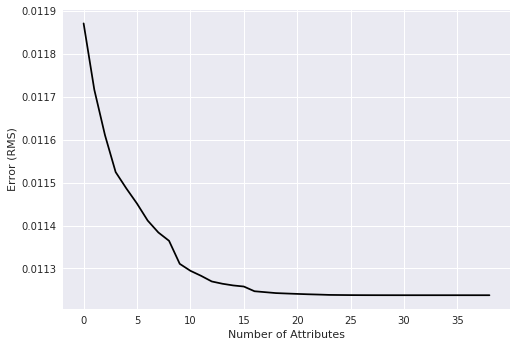

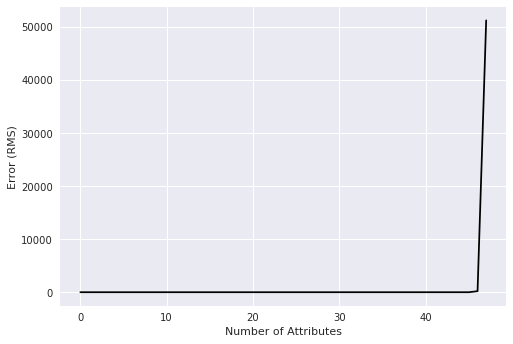

In [26]:
namesList, errorList = best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


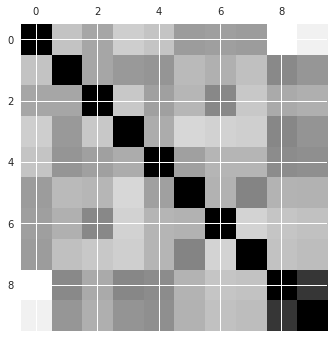

In [27]:
df[namesList[0:10]].corr()

### DV: Parent citation (rename the variable)

In [28]:
# myX = df.as_matrix(columns=chosenColumns)

# myY = df.as_matrix(columns=['parent_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
# testSize = yTest.shape[0]
# trainSize = yTrain.shape[0]
# namesList, errorList = best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

In [29]:
# This selector does not work because almost every attribute is p-value significant

# selector = SelectKBest(f_classif, k=4) #initialize 
# selector.fit(myX, myY) #fit
# scores = -np.log10(selector.pvalues_) #transform pvalues (why?)
# scores /= scores.max() #normalize 
# plt.bar(myX - .45, scores, width=.2,
#         label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
#         edgecolor='black')

In [30]:
# nbayes(xTrain, yTrain, xTest, yTest)

In [31]:
# #Let's do something else
# #Change the DV 

# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['parent_back_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 

In [32]:
# nbayes(xTrain, yTrain, xTest, yTest)

In [33]:
# df.parent_back_citation.boxplot()

In [34]:
#and graphs of back citation in time

In [35]:
# for i in classifications:
#     rank=df.groupby(i).count().iloc[:,2].sort_values(ascending=False).reset_index().set_index(i)
#     description=df_class[df_class['class']==i].set_index('id')
#     display(rank.join(description))

In [36]:
# for i in obj_cols:
#     if i.isin(classifications):
#         df.join(df.groupby(i).count().iloc[:,2].sort_values(ascending=False)
# #     display.display(df.pivot_table(values=df.reset_index().id, index=i, columns='decade', aggfunc='count', fill_value=0, margins=False, dropna=True))
#     print(i)
#     display.display(df.groupby(i).count().iloc[:,2].sort_values(ascending=False))

In [37]:
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x,y)
#     chi2 = ss.chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r-((r-1)**2)/(n-1)
#     kcorr = k-((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [38]:
# all variables
# dtypes={'id':object, 'type':object, 'kind':object, 'num_claims':float, 'cit_received':float, 'cit_made':float,
#        'cit_received_delay':float, 'cit_made_delay':float, 'parent_citation':float,
#        'originality':float, 'generality':float, 'wipo_field_id':object, 'ipcr_section':object,
#        'cpc_section_id':object,'nber_category_id':object,'uspc_mainclass_id':object}